In [1]:
# Importing libraries
import os, shutil, random
import tensorflow as tf 
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Directory path
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'

In [3]:
# Configs for image Generator
target_size = (150, 150)
train_batch = 4710
test_batch = 522
val_batch = 624

In [4]:
train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     test_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
# Reshaping images
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [8]:
import numpy as np
train_y = np.reshape(train_labels[:,0], (4710,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (522,1))

Looking at the above images, it's hard to infer much to an untrained eye. The images look very similar to each other.

The x-rays also all look pretty standard in terms of rotation and angle -- that means we probably don't need to worry about generating additional training images.

### Data Distribution

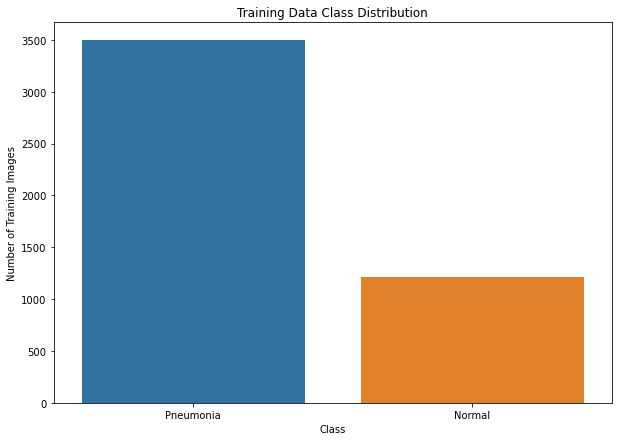

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.barplot(y=[sum(train_y==0)[0], sum(train_y==1)[0]],
            x=['Pneumonia', 'Normal'],
           orient ='v')
plt.title('Training Data Class Distribution')
plt.ylabel('Number of Training Images')
plt.xlabel('Class')
plt.show()

### Baseline model

In [10]:
# Build a baseline fully connected model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

baseline_model = Sequential()
baseline_model.add(layers.Dense(20, activation='relu', input_shape=(target_size[0]*target_size[1]*3,))) # 2 hidden layers
baseline_model.add(layers.Dense(10, activation='relu'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1350020   
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,350,241
Trainable params: 1,350,241
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the image
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history = baseline_model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
148/148 [==============================] - 1s 6ms/step - loss: 0.6575 - acc: 0.7276 - val_loss: 0.3632 - val_acc: 0.7433
Epoch 2/50
148/148 [==============================] - 1s 5ms/step - loss: 0.4030 - acc: 0.7420 - val_loss: 0.4709 - val_acc: 0.7433
Epoch 3/50
148/148 [==============================] - 1s 5ms/step - loss: 0.3371 - acc: 0.8514 - val_loss: 0.2486 - val_acc: 0.9310
Epoch 4/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2985 - acc: 0.8970 - val_loss: 0.2659 - val_acc: 0.9425
Epoch 5/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2709 - acc: 0.9176 - val_loss: 0.2342 - val_acc: 0.9253
Epoch 6/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2560 - acc: 0.9227 - val_loss: 0.6231 - val_acc: 0.5460
Epoch 7/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2488 - acc: 0.9229 - val_loss: 0.2400 - val_acc: 0.9119
Epoch 8/50
148/148 [==============================] - 1s 5ms/step - loss: 0.

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def evaluate_results(model, x, y):
    y_hat_test = model.predict(x)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = y.astype(np.int)
    #labels = ['NORMAL', 'PNEUMONIA']
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm
                                  #display_labels=labels
                                 )
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred)
    print('F1 score: %f' % f1)

17/17 [==============================] - 0s 2ms/step


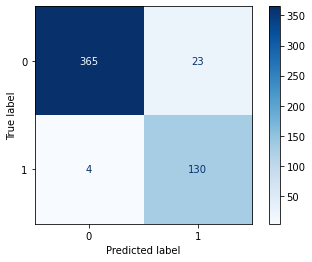

Accuracy: 0.948276
Precision: 0.849673
Recall: 0.970149
F1 score: 0.905923


In [14]:
evaluate_results(baseline_model, val_img, val_y)

Our baseline model is doing quite poorly. It's only predicting the dominant class all the time.

### Iteration 1 - Increasing Model Complexity

In [15]:
iter_1_model = Sequential()
iter_1_model.add(layers.Dense(20, activation='relu', input_shape=(target_size[0]*target_size[1]*3,)))
iter_1_model.add(layers.Dense(7, activation='relu'))
iter_1_model.add(layers.Dense(5, activation='relu'))
iter_1_model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
iter_1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1350020   
                                                                 
 dense_4 (Dense)             (None, 7)                 147       
                                                                 
 dense_5 (Dense)             (None, 5)                 40        
                                                                 
 dense_6 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,350,213
Trainable params: 1,350,213
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Compile the image
iter_1_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

history_2 = iter_1_model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Epoch 1/50
148/148 [==============================] - 1s 6ms/step - loss: 0.5059 - acc: 0.7639 - val_loss: 0.4592 - val_acc: 0.7625
Epoch 2/50
148/148 [==============================] - 1s 5ms/step - loss: 0.3489 - acc: 0.8510 - val_loss: 0.9078 - val_acc: 0.4655
Epoch 3/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2586 - acc: 0.8928 - val_loss: 0.2109 - val_acc: 0.9234
Epoch 4/50
148/148 [==============================] - 1s 5ms/step - loss: 0.2300 - acc: 0.9040 - val_loss: 0.1353 - val_acc: 0.9502
Epoch 5/50
148/148 [==============================] - 1s 5ms/step - loss: 0.1947 - acc: 0.9242 - val_loss: 0.4199 - val_acc: 0.8352
Epoch 6/50
148/148 [==============================] - 1s 5ms/step - loss: 0.1918 - acc: 0.9255 - val_loss: 0.1498 - val_acc: 0.9330
Epoch 7/50
148/148 [==============================] - 1s 5ms/step - loss: 0.1673 - acc: 0.9333 - val_loss: 0.4105 - val_acc: 0.8429
Epoch 8/50
148/148 [==============================] - 1s 5ms/step - loss: 0.

17/17 [==============================] - 0s 2ms/step


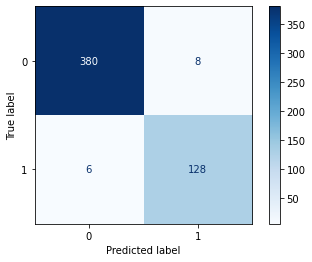

Accuracy: 0.973180
Precision: 0.941176
Recall: 0.955224
F1 score: 0.948148


In [18]:
evaluate_results(iter_1_model, val_img, val_y)

This is better, but now this model is starting to miss penumonia cases. It mislabeled 15 cases.

### CNN
Convolutional Neural Networks (CNNs) are an algorithm well-suited for image processing tasks. They pass filters over an image and assign importance to different feature images for classification. This can make them well-suited for the task at hand, as we're trying to detect Pneumonia.

In [19]:
#Build the first CNN model
from tensorflow.keras import models

first_cnn_model = models.Sequential()

first_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(target_size[0], target_size[1], 3 )))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
first_cnn_model.add(layers.MaxPooling2D((2, 2)))

first_cnn_model.add(layers.Flatten())
first_cnn_model.add(layers.Dense(64, activation='relu'))
first_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
# Compile
first_cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [21]:
first_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)      

In [22]:
# Fit the model
tf.config.run_functions_eagerly(True)
cnn_history = first_cnn_model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Epoch 1/30
148/148 [==============================] - 49s 330ms/step - loss: 0.5567 - acc: 0.7448 - val_loss: 0.5097 - val_acc: 0.7433
Epoch 2/30
148/148 [==============================] - 49s 333ms/step - loss: 0.4304 - acc: 0.7996 - val_loss: 0.4746 - val_acc: 0.7663
Epoch 3/30
148/148 [==============================] - 49s 330ms/step - loss: 0.3122 - acc: 0.8764 - val_loss: 0.2477 - val_acc: 0.9176
Epoch 4/30
148/148 [==============================] - 49s 330ms/step - loss: 0.2270 - acc: 0.9089 - val_loss: 0.3920 - val_acc: 0.8352
Epoch 5/30
148/148 [==============================] - 49s 330ms/step - loss: 0.1886 - acc: 0.9240 - val_loss: 0.1453 - val_acc: 0.9579
Epoch 6/30
148/148 [==============================] - 49s 329ms/step - loss: 0.1635 - acc: 0.9359 - val_loss: 0.4363 - val_acc: 0.8123
Epoch 7/30
148/148 [==============================] - 49s 329ms/step - loss: 0.1641 - acc: 0.9384 - val_loss: 0.1148 - val_acc: 0.9598
Epoch 8/30
148/148 [==============================] - 4

17/17 [==============================] - 1s 77ms/step


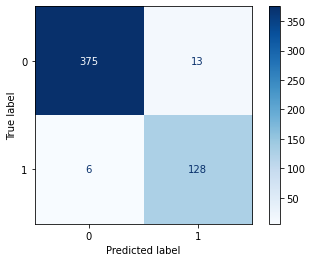

Accuracy: 0.963602
Precision: 0.907801
Recall: 0.955224
F1 score: 0.930909


In [23]:
evaluate_results(first_cnn_model, val_images, val_y)

### Visualizing Intermediate Activations

(1, 150, 150, 3)


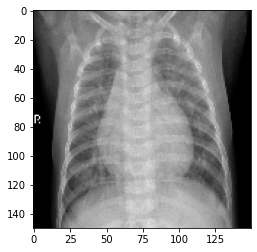

In [24]:
# Loading an image
from tensorflow.keras.preprocessing import image
img_path = 'chest_xray/train/PNEUMONIA/BACTERIA-30629-0001.jpeg'


img = image.load_img(img_path, target_size=target_size)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

1/1 [==============================] - 0s 20ms/step


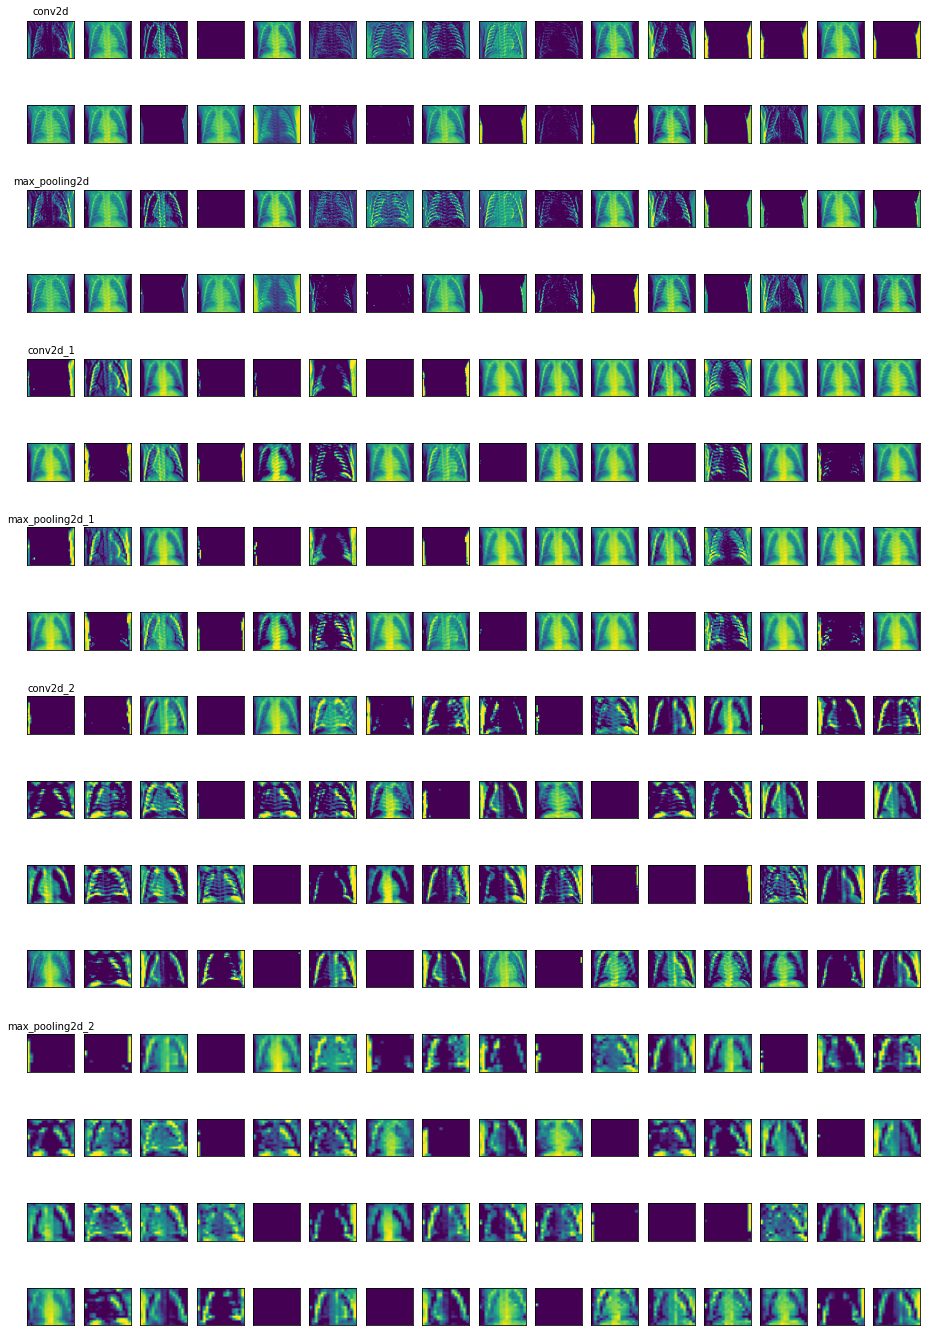

In [25]:
import math 

## Extract model layer outputs
layer_outputs = [layer.output for layer in first_cnn_model.layers[:6]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=first_cnn_model.input, outputs=layer_outputs)

# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

layer_names = []

for layer in first_cnn_model.layers[:6]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.show()

### Histogram Equalization
Histogram Equalization increases contrast in images by detecting the distribution of pixel densities in an image and plotting these pixel densities on a histogram.

[Research](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949) published in 2022 showed that using Histogram Equalization led to improved performence of CNNs in image classification tasks for Pneumonia and COVID-19. We will try to implementat those here.

To implement this using ImageDataGenerator, we will follow [this guide](https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085).

In [26]:
# Find the image.py file on our machine
import keras
print(keras.__file__)

C:\Users\Robert\anaconda3\envs\learn-env\lib\site-packages\keras\__init__.py


In [27]:
from image_altered import ImageDataGenerator2 as idg

In [30]:
train_hist_generator = idg(rescale=1./255, 
                           histogram_equalization=True,
                           validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 4710,
                                                     subset='training',
                                                     seed=123)

val_hist_generator = idg(rescale=1./255, 
                           histogram_equalization=True,
                           validation_split=0.1).flow_from_directory(
                                                     train_path,
                                                     target_size=target_size,
                                                     batch_size = 522,
                                                     subset='validation',
                                                     seed=123)

test_hist_generator = idg(rescale=1./255,
                          histogram_equalization=True).flow_from_directory(
                                                     test_path,
                                                     target_size=target_size,
                                                     batch_size=624,
                                                     seed=123)

# create the data sets
train_hist_images, train_hist_labels = next(train_hist_generator)
test_hist_images, test_hist_labels = next(val_hist_generator)
val_hist_images, val_hist_labels = next(test_hist_generator)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [31]:
import numpy as np
train_hist_y = np.reshape(train_hist_labels[:,0], (4710,1))
test_hist_y = np.reshape(test_hist_labels[:,0], (522,1))
val_hist_y = np.reshape(val_hist_labels[:,0], (624,1))

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models

second_cnn_model = models.Sequential()

second_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(target_size[0], target_size[1], 3 )))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
second_cnn_model.add(layers.MaxPooling2D((2, 2)))

second_cnn_model.add(layers.Flatten())
second_cnn_model.add(layers.Dense(64, activation='relu'))
second_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [33]:
second_cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [34]:
# Fit the model
tf.config.run_functions_eagerly(True)
cnn_2_history = second_cnn_model.fit(train_hist_images,
                    train_hist_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_hist_images, val_hist_y))

Epoch 1/30
148/148 [==============================] - 49s 333ms/step - loss: 0.5420 - acc: 0.7444 - val_loss: 0.5323 - val_acc: 0.6474
Epoch 2/30
148/148 [==============================] - 49s 330ms/step - loss: 0.4100 - acc: 0.8225 - val_loss: 1.7031 - val_acc: 0.6250
Epoch 3/30
148/148 [==============================] - 49s 334ms/step - loss: 0.2819 - acc: 0.8847 - val_loss: 0.5467 - val_acc: 0.7516
Epoch 4/30
148/148 [==============================] - 51s 344ms/step - loss: 0.2193 - acc: 0.9115 - val_loss: 0.4917 - val_acc: 0.8045
Epoch 5/30
148/148 [==============================] - 50s 337ms/step - loss: 0.1804 - acc: 0.9325 - val_loss: 0.3967 - val_acc: 0.8381
Epoch 6/30
148/148 [==============================] - 49s 328ms/step - loss: 0.1625 - acc: 0.9369 - val_loss: 0.4172 - val_acc: 0.8446
Epoch 7/30
148/148 [==============================] - 50s 339ms/step - loss: 0.1550 - acc: 0.9406 - val_loss: 0.3167 - val_acc: 0.8766
Epoch 8/30
148/148 [==============================] - 4

17/17 [==============================] - 1s 75ms/step


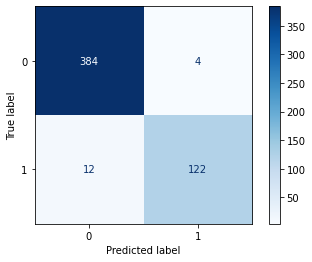

Accuracy: 0.969349
Precision: 0.968254
Recall: 0.910448
F1 score: 0.938462


In [35]:
evaluate_results(second_cnn_model, val_images, val_y)

1/1 [==============================] - 0s 21ms/step


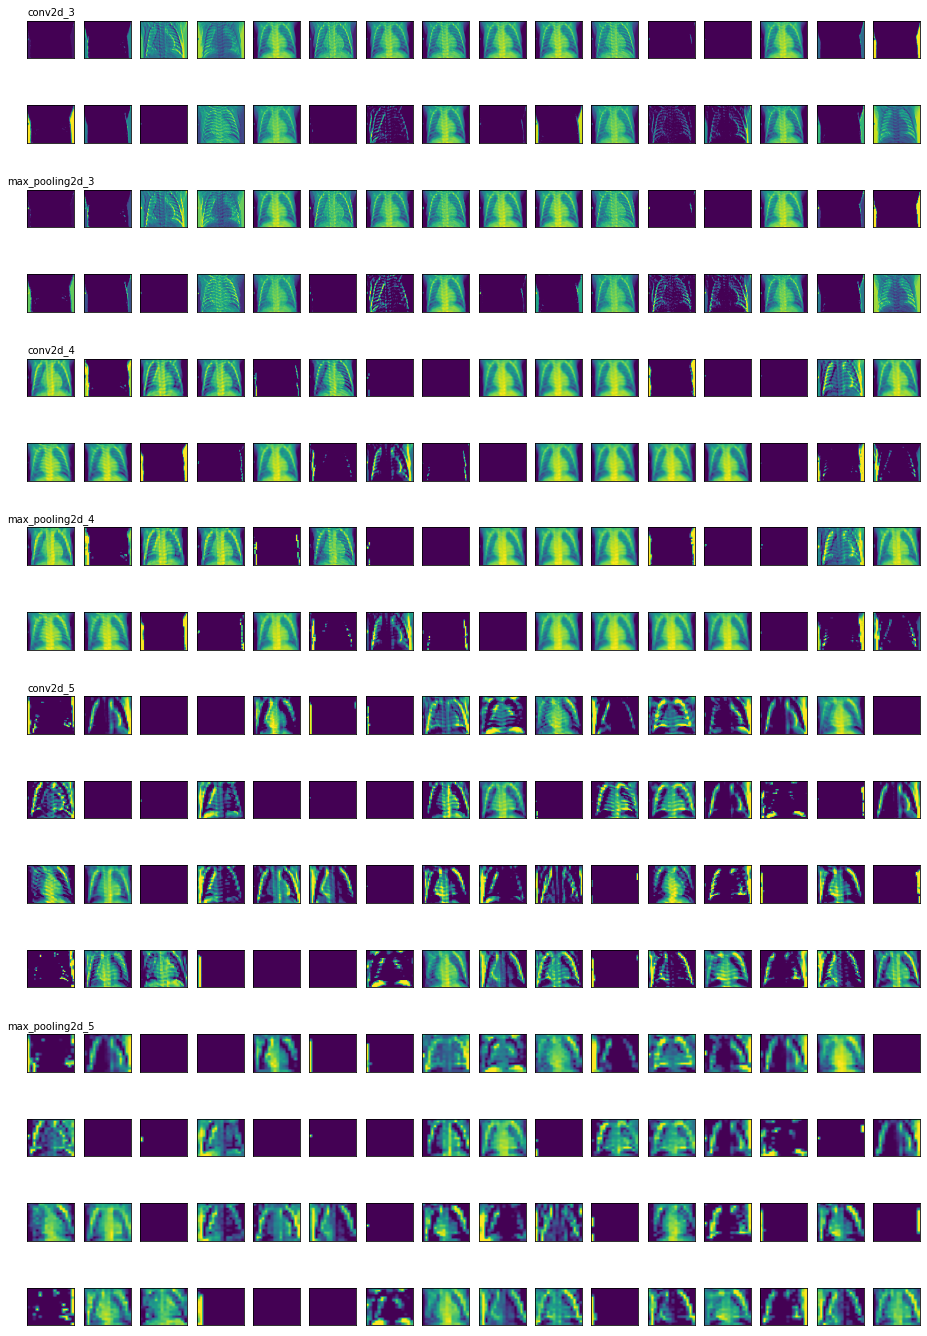

In [36]:
## Extract model layer outputs
layer_outputs = [layer.output for layer in second_cnn_model.layers[:6]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=second_cnn_model.input, outputs=layer_outputs)

# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

layer_names = []

for layer in second_cnn_model.layers[:6]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.show()